# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


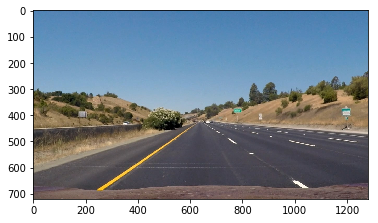

In [11]:
#reading in an image
image = cv2.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Tracking class

In [12]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent left fit
        self.current_lfit = [np.array([False])]
        #polynomial coefficients for the most recent right fit
        self.current_rfit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last left and new left fits
        self.ldiffs = np.array([0,0,0], dtype='float') 
        #difference in fit coefficients between last right and new right fits
        self.rdiffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [13]:
import math
import glob

PreviousWindows = []
lastGoodlx = None
lastGoodrx = None
lastGoody = None
mtx = None 
dist = None
linestracked = []
lastlxlow = None
lastlxhigh = None
lastlx_base = None
lastrx_base = None
lastrxlow = None
lastrxhigh = None

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspective_transform(img):
    #Best estimate of perspective transform from src to destination
    #These measurements can be improved upon. It is measured with the slop given 720px of lane lines enbodies ~620 change in x
    #However as distance increases each pixel also represent more pixels in real space
    #I do not know the formula for this estimation however these measurements seems to work
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[708,462],[1137,720],[189,720],[574,462]])
    dst = np.float32([[1137,0],[1137,720],[189,720],[189,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped
#Calibrating based on points given
def calibrat(img, points):
    if points[0] == None or points[1] == None:
        return None
  
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    global mtx
    global dist
    if mtx == None:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points[0], points[1], gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
#trying to get the points such that it may be reusable
def getpoints(imgloc):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(imgloc)
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    #Returning both points
    return objpoints, imgpoints
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    perspectivedivide = 0.6
    topmostleft = np.array([])
    bottommostleft= np.array([])
    topmostright= np.array([])
    bottommostright = np.array([])
    leftslops = []
    rightslops = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1!=x2 and y1!= y2):
                if(float(float(y1-y2)/float(x1-x2))>0):
                    topmostleft = line
                    bottomostleft = line
                if(float(float(y1-y2)/float(x1-x2))<0):
                    topmostright = line
                    bottommostright = line
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1!=x2 and y1!= y2 and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                if(float(float(y1-y2)/float(x1-x2))>0):
                    if(y1<int(topmostleft[0][1])):
                        topmostleft = line
                    if(y1>int(bottomostleft[0][1])):
                        bottomostleft = line
                    leftslops.append(float(y1-y2)/float(x1-x2))
                if(float(float(y1-y2)/float(x1-x2))<0):
                    if(y1<int(topmostright[0][1])):
                        topmostright = line
                    if(y1>int(bottommostright[0][1])):
                        bottommostright = line
                    rightslops.append(float(y1-y2)/float(x1-x2))
                
    if topmostleft.any():
        for x1,y1,x2,y2 in topmostleft:
            if(x1!=x2 and y1!= y2 and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                cv2.line(    img, (x1+int(float(imshape[0]/1.68-y1)/float(float(y1-y2)/float(x1-x2))), int(imshape[0]/1.68)), (int(float( imshape[0]*perspectivedivide-y2)/float(float(y1-y2)/float(x1-x2))+x2), int(imshape[0]*perspectivedivide)), color, thickness)
                cv2.line(    img, (x1,y1), (x2,y2),color, thickness)
    if topmostright.any():
        for x1,y1,x2,y2 in topmostright:
            if(x1!=x2 and y1!= y2  and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                cv2.line(    img, (x1+int(float(imshape[0]/1.68-y1)/float(float(y1-y2)/float(x1-x2))), int(imshape[0]/1.68)), (int(float( imshape[0]*perspectivedivide-y2)/float(float(y1-y2)/float(x1-x2))+x2), int(imshape[0]*perspectivedivide)), color, thickness)
                cv2.line(    img, (x1,y1), (x2,y2),color, thickness)
    if bottommostright.any():
        for x1,y1,x2,y2 in bottommostright:
            if(x1!=x2 and y1!= y2 and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                cv2.line(    img, (x2, y2), (int(float(imshape[0]-y2)/float(float(y1-y2)/float(x1-x2))+x2), imshape[0]), color, thickness)
                cv2.line(    img, (x1+int(float(imshape[0]*perspectivedivide-y1)/get_average_slop(leftslops, rightslops, float(float(y1-y2)/float(x1-x2)))), int(imshape[0]*perspectivedivide)),(x1,y1), color, thickness)
    if bottommostleft.any():
        for x1,y1,x2,y2 in bottommostleft:
            if(x1!=x2 and y1!= y2 and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                cv2.line(    img, (x2, y2), (int(float(imshape[0]-y2)/float(float(y1-y2)/float(x1-x2))+x2), imshape[0]), color, thickness)
                cv2.line(    img, (x1+int(float(imshape[0]*perspectivedivide-y1)/get_average_slop(leftslops, rightslops, float(float(y1-y2)/float(x1-x2)))), int(imshape[0]*perspectivedivide)),(x1,y1), color, thickness)

    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1!=x2 and y1!= y2 and (fabs(y1-y2)/fabs(x1-x2))>0.4):
                if(y1<perspectivedivide*imshape[0]):
                    cv2.line(    img, (x1+int(float(imshape[0]/1.68-y1)/float(float(y1-y2)/float(x1-x2))), int(imshape[0]/1.68)), (int(float( imshape[0]*perspectivedivide-y2)/float(float(y1-y2)/float(x1-x2))+x2), int(imshape[0]*perspectivedivide)), color, thickness)
                    cv2.line(    img, (x1,y1), (x2,y2),color, thickness)
                else:
                    cv2.line(    img, (x2, y2), (int(float(imshape[0]-y2)/get_average_slop(leftslops, rightslops, float(float(y1-y2)/float(x1-x2)))+x2), imshape[0]), color, thickness)
                    cv2.line(    img, (x1+int(float(imshape[0]*perspectivedivide-y1)/get_average_slop(leftslops, rightslops, float(float(y1-y2)/float(x1-x2)))), int(imshape[0]*perspectivedivide)),(x1,y1), color, thickness)

def get_average_slop(leftslops, rightslops, direction):
    if(direction>0):
        return sum(s for s in leftslops)/len(leftslops)
    return sum(s for s in rightslops)/len(rightslops)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = hough_lineslines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255,0,0], 10)
    return line_img
def hough_lineslines(img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Python 3 has support for cool math symbols.
#Undo the transform
def detransform(img):
    #going from destination to source
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[708,462],[1137,720],[189,720],[574,462]])
    dst = np.float32([[1137,0],[1137,720],[189,720],[189,0]])
    M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
#Refactored this to be reusable and more usable
def draw_on_undistorted(undist, warped, ploty, left_fitx, right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using destransform implemented
    newwarp = detransform(color_warp) 
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
def polylines(undist, binary_warped, lastbase = True):
    #Getting the histogram graph based on sum of binary values over x
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #Getting image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #Taking midpoint
    midpoint = np.int(histogram.shape[0]/2)
    #As a business application developer I am ashame of using global
    global lastlx_base, lastrx_base
    #If these were never set then take them as the mid points based on max value of peak
    if lastbase == False or lastlx_base == None:
        lastlx_base = np.argmax(histogram[:midpoint])
        lastrx_base = np.argmax(histogram[midpoint:]) + midpoint
    #Set the bases as the last saved base
    leftx_base = lastlx_base  
    rightx_base = lastrx_base
    global lastGoodlx, lastGoodrx, lastGoody
    #If last bases are too close to the center then draw the last good fit and save the current assumed base as last base
    if lastlx_base > midpoint-300 or lastrx_base < midpoint+300:    
        if lastGoody != None:
            lastlx_base = np.argmax(histogram[:midpoint])
            lastrx_base = np.argmax(histogram[midpoint:]) + midpoint
            return draw_on_undistorted(undist, binary_warped, lastGoody, lastGoodlx, lastGoodrx)
    
    #Take the fit using sliding window
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    if lastlxlow == None:
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0:
        return draw_on_undistorted(undist, binary_warped, lastGoody, lastGoodlx, lastGoodrx)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Start tracking the lines
    trackline = Line()
    lastlfit = [np.array([False])]
    lastrfit = [np.array([False])]
    #Check the last saved fit to calculate the left diff and right diff against previous
    if len(linestracked) > 0:
        lastlfit = linestracked[len(linestracked)-1].current_lfit
        lastrfit = linestracked[len(linestracked)-1].current_rfit
    if(lastlfit[0] == False or lastrfit[0] == False):
        #set the diff as non if there was no previous fit
        trackline.ldiffs = None
        trackline.rdiffs = None
    else:
        trackline.ldiffs = np.diff([lastlfit, left_fit])
        trackline.rdiffs = np.diff([lastrfit, right_fit])
    #save the current fit
    trackline.current_lfit = left_fit
    trackline.current_rfit = right_fit
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/639 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
   
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #Save the curvature inside of the line for later display
    trackline.radius_of_curvature = left_curverad, right_curverad
    
    linestracked.append(trackline)
    #If there is no problem then fit is good and we save the fit as last good fit
    if not isThereProblem():
        lastGoodlx = left_fitx
        lastGoodrx = right_fitx
        lastGoody = ploty
        #We draw it
        result = draw_on_undistorted(undist, binary_warped, ploty, left_fitx, right_fitx)
    else:
        if lastbase:
            #If we were basing it off of last good fit then we will try again by recalculating the left and right base
            result = polylines(undist, binary_warped, lastbase = False)
        elif lastGoody != None:
            #Otherwise we just draw the last good fit
            result = draw_on_undistorted(undist, binary_warped, lastGoody, lastGoodlx, lastGoodrx)   
    cv2.putText(result,"Radius of curvature is "+ str(left_curverad)+" m", (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 4)
    awayfromcenter = undist.shape[1]/2-(np.argmax(histogram[:midpoint])+((np.argmax(histogram[midpoint:]) + midpoint) - np.argmax(histogram[:midpoint]))/2)
    if awayfromcenter < 0:
        cv2.putText(result,"Vehicle is "+ str(abs(xm_per_pix*awayfromcenter))+" m left of center.", (10,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 4)
    else:
        cv2.putText(result,"Vehicle is "+ str(abs(xm_per_pix*awayfromcenter))+" m right of center.", (10,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 4)
    return result
#There is a problem if the differences for left is greater than 1100 or 2700 for right
def isThereProblem():
    leftdiff, rightdiff = computeDiffs()
    return leftdiff > 1100 or rightdiff > 2700
#Take the absolute sum of the diffs and return them
#If there no lines tracked then return 0,0
def computeDiffs():
    if linestracked[len(linestracked)-1].ldiffs != None:
        leftdiff = np.sum(np.absolute(linestracked[len(linestracked)-1].ldiffs))
        rightdiff = np.sum(np.absolute(linestracked[len(linestracked)-1].rdiffs))
    else:
        return 0,0
    return leftdiff, rightdiff
def weighted_img(img, initial_img, a=0.8, b=1, lambDa=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, lambDa)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [28]:
import os
listoftiles = [i for i in os.listdir("test_images/") if ".jpg" in i] 
listofcali = os.listdir("camera_cal/")


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

vlcsnap-2017-10-07-14h48m02s694.jpg


c:\Users\Feng\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
c:\Users\Feng\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


vlcsnap-2017-10-07-14h48m21s958.jpg
vlcsnap-2017-10-07-14h48m34s357.jpg
vlcsnap-2017-10-07-14h48m49s282.jpg
vlcsnap-2017-10-07-15h34m55s921.jpg
vlcsnap-2017-10-28-23h34m23s194.jpg
vlcsnap-2017-10-28-23h34m36s493.jpg
vlcsnap-2017-10-28-23h35m00s184.jpg
vlcsnap-2017-10-28-23h35m08s260.jpg
vlcsnap-2017-10-28-23h35m14s612.jpg
vlcsnap-2017-10-28-23h35m21s429.jpg
vlcsnap-2017-10-28-23h35m27s953.jpg
vlcsnap-2017-10-28-23h35m37s972.jpg
vlcsnap-2017-10-28-23h35m47s820.jpg
vlcsnap-2017-10-28-23h35m54s894.jpg
vlcsnap-2017-10-28-23h36m05s418.jpg
vlcsnap-2017-10-28-23h36m13s238.jpg
vlcsnap-2017-10-28-23h36m23s758.jpg
vlcsnap-2017-10-28-23h37m04s255.jpg


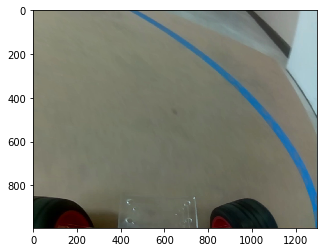

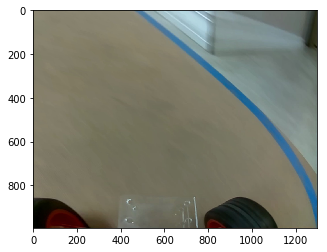

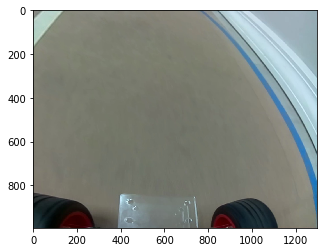

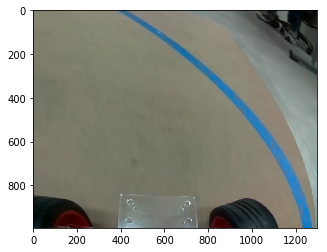

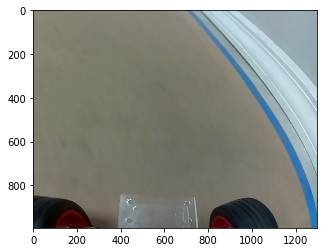

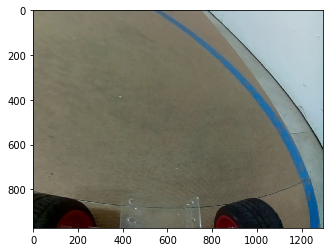

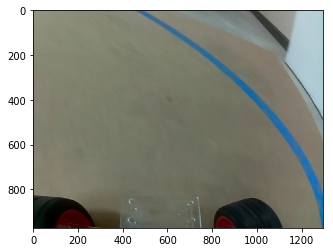

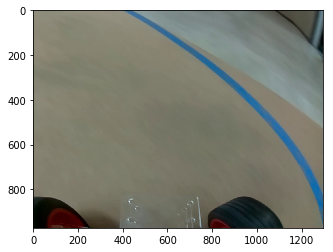

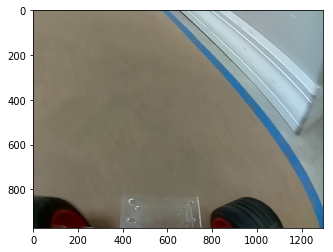

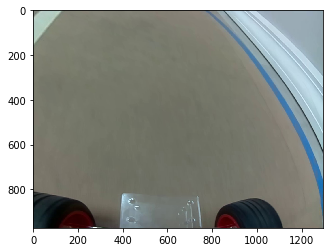

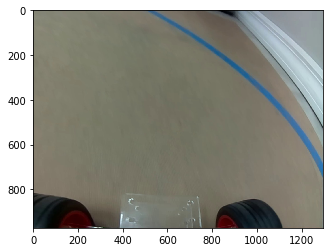

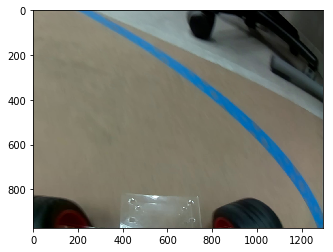

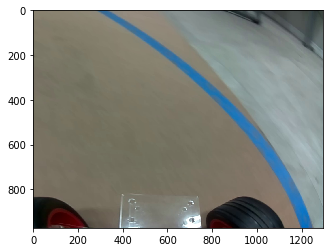

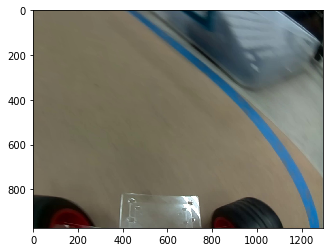

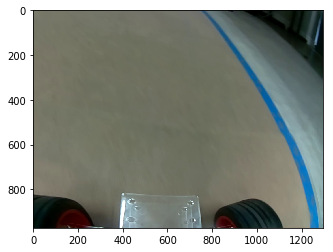

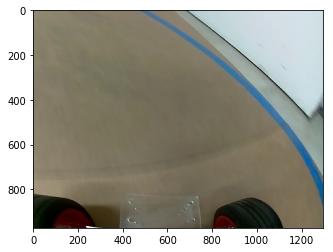

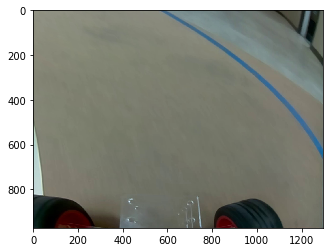

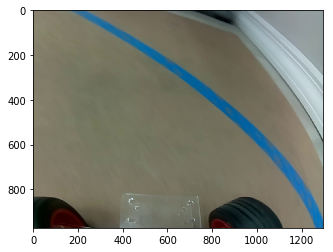

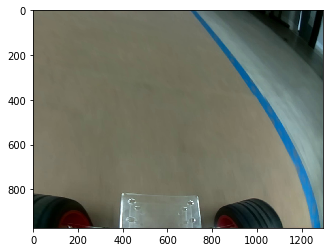

In [29]:
#Making use of the calibration and showing and saving the result
if points == None:
    points = getpoints('camera_cal/*')
#for file in listofcali:
#    plt.figure()
#    calimg = calibrat(cv2.cvtColor(cv2.imread('camera_cal/'+file), cv2.COLOR_BGR2RGB), points)
#    if calimg != None:
#        plt.imshow(calimg)
#        cv2.imwrite("test_output_images/"+file,calimg )

for file in listoftiles:
    plt.figure()
    print(file)
    calimg = calibrat(cv2.cvtColor(cv2.imread('test_images/'+file), cv2.COLOR_BGR2RGB), points)
    if calimg != None:
        plt.imshow(calimg)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from imageio import plugins
plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    #Undistort the image first
    img = calibrat(image, points)

    #Get the hls channel values
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Extracting the saturation and hue channels
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    #Converting image to grayscale to obtain the sobelx calculation
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #Calculating the absolute sobelx
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    #Calculating the binary of sobelx based on thresh holds
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    #Calculating the binary of saturation channel based on thresh holds
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    h_thresh_min = 50
    h_thresh_max = 100
    #The hue was taken too but not used
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (h_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1
    #Apply perspective transform on the binary image
    cv2.imwrite("examples/binaryex.png",combined_binary*255)
    combined_binary =perspective_transform( combined_binary)
    #Returning with the poly line area drawn on the image
    cv2.imwrite("examples/binaryexTransformed.png",combined_binary*255)
    return polylines(img,combined_binary)

19563.6347348 m 43346.2943165 m
30657.1947737 m 49266.9842613 m
leftDiff: 436.607212094
rightDiff: 2245.87769333
1062.62157553 m 19324.52435 m
leftDiff: 556.017619778
rightDiff: 2425.87220692
816.737654852 m 600.43538979 m
leftDiff: 509.189179988
rightDiff: 2336.20793108
2043.7829182 m 2586.58470323 m
leftDiff: 599.44587905
rightDiff: 2342.97063492
3167.46487561 m 5686.78935243 m
leftDiff: 761.156512454
rightDiff: 2575.31610933
812.480033125 m 4210.45939598 m
leftDiff: 629.67539267
rightDiff: 2541.55334762
1559.22729937 m 1069.08214403 m
leftDiff: 769.828335755
rightDiff: 2537.00663555


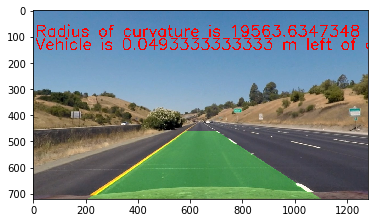

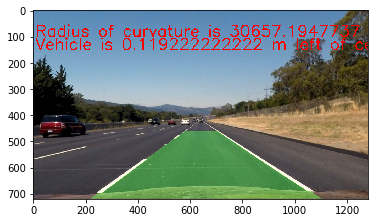

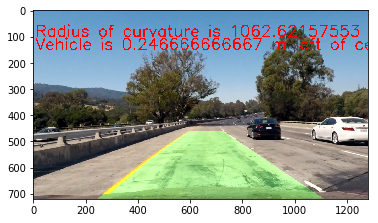

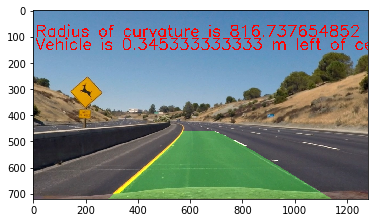

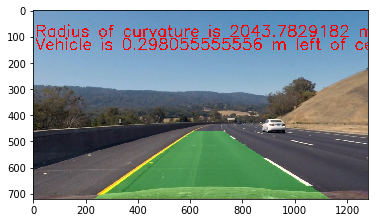

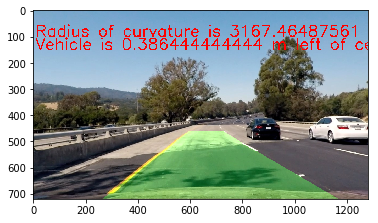

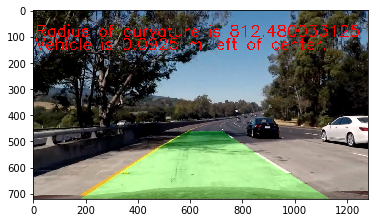

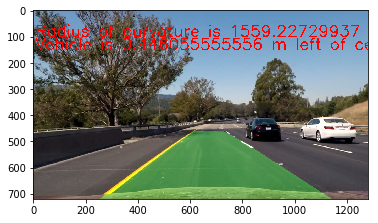

In [14]:
import numpy as np
from decimal import *
from math import *
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
if not os.path.exists('test_images_output'):
    os.makedirs('test_images_output')
linestracked = []
global lastlx_base, lastrx_base, lastGoodlx, lastGoodrx, lastGoody
lastGoodlx = None
lastGoodrx = None
lastGoody = None
lastlx_base = None
lastrx_base = None
img = None
for file in listoftiles:
    plt.figure()
    result=process_image(cv2.cvtColor(cv2.imread('test_images/'+file), cv2.COLOR_BGR2RGB))
    plt.imshow(result)
    leftcurve, rightcurve = linestracked[len(linestracked)-1].radius_of_curvature
    cv2.imwrite("output_images/"+file,result)
    print(leftcurve, 'm', rightcurve, 'm')
    if linestracked[len(linestracked)-1].ldiffs != None:
        leftdiff = np.sum(np.absolute(linestracked[len(linestracked)-1].ldiffs))
        rightdiff = np.sum(np.absolute(linestracked[len(linestracked)-1].rdiffs))
        print("leftDiff: "+str(leftdiff))
        print("rightDiff: "+str(rightdiff))
    
    
    



    



Let's try the one with the solid white lane on the right first ...

In [15]:
import os
if not os.path.exists('test_videos_output'):
    os.makedirs('test_videos_output')
global lastlx_base, lastrx_base, lastGoodlx, lastGoodrx, lastGoody
lastGoodlx = None
lastGoodrx = None
lastGoody = None
lastlx_base = None
lastrx_base = None
linestracked = []
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [16:02<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 16min 11s


In [14]:
for i in range(0, len(linestracked)-1):
    lt = linestracked[i]
    if lt.ldiffs != None and (np.sum(np.absolute(lt.ldiffs))>1100 or np.sum(np.absolute(lt.rdiffs))>2700):
        print("problem at frame "+str(i+1)+" leftdiff: "+str( np.sum(np.absolute(lt.ldiffs))) + " rightdiff: "+str(np.sum(np.absolute(lt.rdiffs))))

problem at frame 761 leftdiff: 7088.82658093 rightdiff: 2555.59547574
problem at frame 762 leftdiff: 7094.16272879 rightdiff: 2578.0460295
problem at frame 766 leftdiff: 1012.92276074 rightdiff: 2724.01717343
problem at frame 767 leftdiff: 1009.56027051 rightdiff: 2749.30051753
problem at frame 768 leftdiff: 1013.04052163 rightdiff: 2749.05561239
problem at frame 769 leftdiff: 1016.58702265 rightdiff: 2748.81070726
problem at frame 885 leftdiff: 689.707407311 rightdiff: 2702.21401024
problem at frame 886 leftdiff: 694.871952824 rightdiff: 2703.73440517
problem at frame 1046 leftdiff: 748.873049384 rightdiff: 2743.17509104
problem at frame 1047 leftdiff: 741.141028477 rightdiff: 2737.50869434
problem at frame 1048 leftdiff: 750.802411935 rightdiff: 2731.62510301
problem at frame 1049 leftdiff: 760.916006433 rightdiff: 2727.84268643
problem at frame 1050 leftdiff: 743.037151553 rightdiff: 2765.0954115
problem at frame 1051 leftdiff: 725.274382728 rightdiff: 2802.85719341
problem at frame

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
global lastlx_base, lastrx_base, lastGoodlx, lastGoodrx, lastGoody
lastGoodlx = None
lastGoodrx = None
lastGoody = None
lastlx_base = None
lastrx_base = None
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [08:32<00:00,  1.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 8min 41s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
global lastlx_base, lastrx_base, lastGoodlx, lastGoodrx, lastGoody
lastGoodlx = None
lastGoodrx = None
lastGoody = None
lastlx_base = None
lastrx_base = None
challenge_output = 'test_videos_output/challenge_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [43:52<00:00,  6.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 45min 50s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))